# 프로젝트: Predict Future Sales
팀명: 7ㅐ글조 <br>

---
목표 
* Fundamental 14를 참고하여 데이터 전처리를 수행할 수 있다. 
* Kaggle에서 데이터 정제 ~ 모델 구현까지 수행할 수 있다. 
* 아이스크림 Get! <br>
<br>
사전준비 
* Exploration 8을 수행해온다. 
* Fundamental 8, 9, 11, 14를 복습해온다.  
---
팀 운영   
* notion 페이지 활용했습니다. 

## 데이터 확인

### 디렉토리 경로 확인하기
* 현재 경로를 확인한다. 
* project path, data_path를 지정하고 확인한다. 
* data_path 안에 있는 파일 리스트를 확인한다. 

In [1]:
import gc 
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
from os.path import join
import random
import numpy as np 
import os
import itertools

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.model_selection import RandomizedSearchCV

from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb
import lightgbm as lgb

In [2]:
!pwd

/home/aiffel-dj19/aiffel/kaggle_predict_sales


In [3]:
os.getcwd()

'/home/aiffel-dj19/aiffel/kaggle_predict_sales'

In [4]:
project_path = os.path.join(os.getcwd()) # project path 지정
project_path

'/home/aiffel-dj19/aiffel/kaggle_predict_sales'

In [5]:
data_path = os.path.join(os.getcwd(), 'data') # data path 지정 
data_path

'/home/aiffel-dj19/aiffel/kaggle_predict_sales/data'

In [6]:
!ls

'[K-7]PredictFutureSales (copy).ipynb'	 data
'[K-7]PredictFutureSales.ipynb'		 untitled.txt
'[K-7]PredictFutureSales_final.ipynb'


In [7]:
# %cd /home/aiffel-dj19/aiffel/kaggle_predict_sales/data

In [8]:
# !ls

In [9]:
file_list = os.listdir(data_path)

for file in file_list:
    print(file)

submission_lgb2_RMSE.csv
items_en.csv
sales_train.csv
test.csv
submission_lgb_RMSE.csv
data.pkl
submission_xgb3_RMSE.csv
shops_en.csv
submission_xgb2_RMSE.csv
sample_submission.csv
item_categories_en.csv
submission_xgb_RMSE.csv


In [10]:
data_path

'/home/aiffel-dj19/aiffel/kaggle_predict_sales/data'

---

### 데이터 불러오기 & 확인하기

In [11]:
# data path 하위 파일들 불러오기 
cats = pd.read_csv(join(data_path, 'item_categories_en.csv')) # '/' 안해줘도 됨
items = pd.read_csv(join(data_path, 'items_en.csv'))
shops = pd.read_csv(join(data_path, 'shops_en.csv'))
train = pd.read_csv(join(data_path, 'sales_train.csv'))
test = pd.read_csv(join(data_path, 'test.csv'))
samsub = pd.read_csv(join(data_path, 'sample_submission.csv'))

In [12]:
# data 개수 확인 
print('cats: {}'.format(cats.shape))
print('items: {}'.format(items.shape))
print('shops: {}'.format(shops.shape))
print('train: {}'.format(train.shape))
print('test: {}'.format(test.shape))
print('samsub: {}'.format(samsub.shape))

cats: (84, 2)
items: (22170, 3)
shops: (60, 2)
train: (2935849, 6)
test: (214200, 3)
samsub: (214200, 2)


#### ✅ item_categories_en -> cats
item_categories 안에는 악세사리, PC-헤드셋, 티켓, 배달 굿즈 등이 있습니다. <br> 
id 같은 경우 위에서부터 인덱스 역할을 하는 값으로 보입니다.  <br> 
악세사리를 살펴봤을 때 PS2, PS3, PS4, PSP, XBOX 등 게임 콘솔 관련 기기들로 보입니다. 

In [13]:
cats.head()

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4


In [14]:
cats.tail()

,item_category_name,item_category_id
79,System Tools,79
80,Utilities - Tickets,80
81,Net carriers (spire),81
82,Net carriers (piece),82
83,batteries,83


#### ✅ items_en -> items
! ABBYY FineReader 12 Professional Edition Ful...는 프로그램 이름으로 구글링됩니다. <br>
*** Tea with Mussolini D는 영화 같아 보임 <br> 
items_categories에 포함되는 아이템들 리스트로 보인다. <br>
공통적으로 드러나는 특징이 괄호 안에 UNV, UNI, PLAST., !가 대문자로 있는게 있고 별이 3개가 있는게 있다. 이것도 뭔가 의미가 있는 것으로는 보인다. 특수문자는 정확히 모르겠으나 러시아어 -> 영어로 번역되는 과정에서 오는 생략기호 같기도 하다. 전처리가 필요하거나, 생략한 단어가 될 수 있어 보인다. <br>
카테고리 id 부분이 40번에 해당하는 Tea, NEW이 영화로 검색이 되었습니다. <br>

In [15]:
items.head()

,item_name,item_id,item_category_id
0,! POWER IN glamor (PLAST.) D,0,40
1,! ABBYY FineReader 12 Professional Edition Ful...,1,76
2,*** In the glory (UNV) D,2,40
3,*** BLUE WAVE (Univ) D,3,40
4,*** BOX (GLASS) D,4,40


item_name이 짤려서 뒤에 반복되는 D의 패턴을 알기 위해 특정 컬럼을 슬라이싱해줬습니다. <br> 
괄호나, D나 여러 종류가 끝에 있는데, 특정 패턴이 보이지 않아서 해당 불용어 제거를 해주거나 아니면 해당 데이터는 사용하지 않고 id만 고려를 해주는게 좋을지 확인 필요해보입니다. 

In [16]:
items['item_name'][:50]

0                          ! POWER IN glamor (PLAST.) D
1     ! ABBYY FineReader 12 Professional Edition Ful...
2                              *** In the glory (UNV) D
3                                *** BLUE WAVE (Univ) D
4                                     *** BOX (GLASS) D
5                     *** NEW American Graffiti (UNI) D
6                              *** shot on goal (UNI) D
7                            *** shot on goal-2 (UNI) D
8                              *** Tea with Mussolini D
9                     *** SHUGARLENDSKY EXPRESS (UNI) D
10                                     * BEYOND DEATH D
11                                       * DEATH LINE D
12                        * Micah Jumanji Amores Perros
13                                     * SAVING EMILY D
14                        * Nutty Professor / MAGIC / D
15                   // Crank: One against all (Region)
16                        // Mongolia S.Bodrov (Region)
17                              // Untraceable (

#### ✅ shops_en -> shops
주소, 나라 등이 나타나 있고 Mega, Mall처럼 쇼핑센터도 있고, 나라별 도시가 있어서 도시별로 데이터를 살펴봐도 좋을거 같습니다. shop_name에서 도시명 추출해서 도시city라는 컬럼 새로 만들어줘서 데이터를 살펴본다. <br> 
판매량 수가 많은 도시에 대해서는 검색을 통해서 그 도시가 수돈지, 관광지인지, 인구가 많은지 이런 특성을 확인해보기로 했습니다. <br>
맨 앞에 있는 단어는 지역이름이라서, 특히 모스코는 수도라 판매량이 많았습니다. 그래서 세봐서 어떤 연관이 있는지 살펴보는 것이 좋을거 같습니다. 

In [17]:
shops.head(10)

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4
5,"Vologda SEC ""Marmalade""",5
6,"Voronezh (Plekhanovskaya, 13)",6
7,"Voronezh SEC ""Maksimir""",7
8,"Voronezh shopping center City Park ""Castle""",8
9,Itinerant trade,9


#### ✅ sales_train -> train
item_id는 2만개대인 것에 비해 train에 있는 개수는 2만대초반이라 백여개 정도의 item은 하나도 안팔린 경우가 있을 수 있습니다. head와 tail을 봤을 때 data_block_num은 월별로 혹은 다른 기주능로 증가합니다. <br>
item_cnt_day(contract => cnt)를 확인해보면 음수 데이터가 있는데 이 부분이 의미하는 바가 환불을 의미하는 것인지 확인해볼 필요가 있어보입니다. <br> 
date가 일, 월, 년도 기준으로 되어있기 때문에 제출할 sample에 맞춰 월별로 확인해볼 필요가 있어보입니다. 

In [18]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [19]:
train.tail()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
2935844,10.10.2015,33,25,7409,299.0,1.0
2935845,09.10.2015,33,25,7460,299.0,1.0
2935846,14.10.2015,33,25,7459,349.0,1.0
2935847,22.10.2015,33,25,7440,299.0,1.0
2935848,03.10.2015,33,25,7460,299.0,1.0


우리가 주어지는 데이터는 Id라는 점이다. 캐글 사이트에서 대회 안내를 확인해보니 다음 달 아이템이 팔리는 개수를 예측하는 문제이므로 item_id는 중요한 컬럼에 해당합니다. 하지만, shop_id는 살펴볼 필요성이 있어보입니다. shop_id도 다음달 판매량을 예측할 때 잘 나가는 가게에 대한 정보도 파악하는 것이 중요해보입니다.<br>
5100개(item_id)*42개(shop_id) = 214200개에 대한 판매량을 맞춰야합니다. 
```
test: (214200, 3)
samsub: (214200, 2)
```

In [20]:
5100*42 # 5100개(item_id)*42개(shop_id)임을 확인했습니다. 

214200

#### ✅ test 및 sample_submission -> test, samsub

In [21]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [22]:
samsub.head()

,ID,item_cnt_month
0,0,0.5
1,1,0.5
2,2,0.5
3,3,0.5
4,4,0.5


#### ✅ 데이터 컬럼 및 컬럼별 개수 확인

In [23]:
print(cats.columns)
print(cats.count())

Index(['item_category_name', 'item_category_id'], dtype='object')
item_category_name    84
item_category_id      84
dtype: int64


In [24]:
print(items.columns)
print(items.count()) 

Index(['item_name', 'item_id', 'item_category_id'], dtype='object')
item_name           22170
item_id             22170
item_category_id    22170
dtype: int64


In [25]:
print(shops.columns)
print(shops.count())

Index(['shop_name', 'shop_id'], dtype='object')
shop_name    60
shop_id      60
dtype: int64


In [26]:
print(train.columns)
print(train.count())

Index(['date', 'date_block_num', 'shop_id', 'item_id', 'item_price',
       'item_cnt_day'],
      dtype='object')
date              2935849
date_block_num    2935849
shop_id           2935849
item_id           2935849
item_price        2935849
item_cnt_day      2935849
dtype: int64


#### ✅ 데이터 중복값 찾기 & 컬럼별 요소의 개수 확인

value_counts() 활용해서 단일 요소에 대한 개수를 세보자 
* 중복 데이터가 있는 칼럼인지 확인한다. - 
* 각 데이터의 요소별 개수를 센다. - value_counts

In [27]:
cats['item_category_name'].duplicated().sum()

0

In [28]:
items['item_name'].duplicated().sum()

20

In [29]:
items['item_category_id'].duplicated().sum() # item_category_id 기준으로 각 요소를 확인해보자

22086

In [30]:
shops['shop_name'].duplicated().sum()

0

In [31]:
print(train.shape)
print(train['item_price'].duplicated().sum())
print(train['date'].duplicated().sum())
print(train['date_block_num'].duplicated().sum())
print(train['shop_id'].duplicated().sum())
print(train['item_id'].duplicated().sum())
print(train['item_price'].duplicated().sum())
print(train['item_cnt_day'].duplicated().sum())

(2935849, 6)
2915856
2934815
2935815
2935789
2914042
2915856
2935651


In [32]:
print(items['item_name'].nunique())
print(shops['shop_name'].nunique())
print(train['date'].nunique())
print(train['item_price'].nunique())

22150
60
1034
19993


위에서 살펴봤을 때, items와 train가 중복 데이터가 존재했고 각 컬럼들이 몇개의 중복개수를 가지는지 확인했습니다. <br> 따라서 두 데이터 프레임에 대해서만 각 요소별 개수를 확인해봤습니다. <br>

In [33]:
items['item_category_id'].value_counts()

40    5035
55    2365
37    1780
31    1125
58     790
      ... 
50       2
1        2
10       1
51       1
79       1
Name: item_category_id, Length: 84, dtype: int64

train를 살펴봤을때 20949가 중복개수가 많다. 데이터 전처리 단계지만 해당 제품이 잘 팔린다는 것을 알 수 있다. 

In [34]:
train['item_id'].value_counts()

20949    31340
5822      9408
17717     9067
2808      7479
4181      6853
         ...  
361          1
3589         1
18784        1
360          1
0            1
Name: item_id, Length: 21807, dtype: int64

2371개 정도 1개만 팔린 제품이 있다. 

In [35]:
(train['item_id'].value_counts() == 1).sum()

2371

In [36]:
(train['item_id'].value_counts() < 100).sum()

15682

---

## 데이터 전처리 및 시각화

### 결측치 확인 및 제거
결측치를 isnull() 함수를 통해 확인했을때 모두 0개임을 확인했습니다. 따라서 제거는 따로 하지 않았습니다. <br> 
* isnull로 null값이 있는지 .values.any()로 유무에 대해서만 판별합니다. 
* sum을 통해 데이터프레임내 각 컬럼별로 결측치를 세줍니다. 

#### 데이터 프레임 결측치 유무 판별 

In [37]:
print(cats.isnull().values.any())
print(items.isnull().values.any())
print(shops.isnull().values.any())
print(train.isnull().values.any())
print(samsub.isnull().values.any())
print(test.isnull().values.any())

False
False
False
False
False
False


In [38]:
items.isnull()

,item_name,item_id,item_category_id
0,False,False,False
1,False,False,False
2,False,False,False
3,False,False,False
4,False,False,False
...,...,...,...
22165,False,False,False
22166,False,False,False
22167,False,False,False
22168,False,False,False


In [39]:
items.isnull().values

array([[False, False, False],
       [False, False, False],
       [False, False, False],
       ...,
       [False, False, False],
       [False, False, False],
       [False, False, False]])

In [40]:
items.isnull().values.any()

False

#### 컬럼별 결측치 개수 확인 

In [41]:
print(cats.isnull().sum())
print(items.isnull().sum())
print(shops.isnull().sum())
print(train.isnull().sum())
print(samsub.isnull().sum())
print(test.isnull().sum())

item_category_name    0
item_category_id      0
dtype: int64
item_name           0
item_id             0
item_category_id    0
dtype: int64
shop_name    0
shop_id      0
dtype: int64
date              0
date_block_num    0
shop_id           0
item_id           0
item_price        0
item_cnt_day      0
dtype: int64
ID                0
item_cnt_month    0
dtype: int64
ID         0
shop_id    0
item_id    0
dtype: int64


In [42]:
print(items.isnull().sum())

item_name           0
item_id             0
item_category_id    0
dtype: int64


### 중복값 확인 및 제거 
```
items: (84, 2)
items: (22170, 3)
shops: (60, 2)
train: (2935849, 6)
test: (214200, 3)
samsub: (214200, 2)
```
불러온 데이터 파일들의 datafram에서 행 기준 모두 일치하는 데이터는 입력상 오류로 판단하고 제거해줍니다. 

In [43]:
cats['item_category_name'] # 컬럼 단위로 데이터 접근 

0     PC - Headsets / Headphones
1              Accessories - PS2
2              Accessories - PS3
3              Accessories - PS4
4              Accessories - PSP
                 ...            
79                  System Tools
80           Utilities - Tickets
81          Net carriers (spire)
82          Net carriers (piece)
83                     batteries
Name: item_category_name, Length: 84, dtype: object

In [44]:
cats.iloc[:] # 행 단위로 데이터 접근 

,item_category_name,item_category_id
0,PC - Headsets / Headphones,0
1,Accessories - PS2,1
2,Accessories - PS3,2
3,Accessories - PS4,3
4,Accessories - PSP,4
...,...,...
79,System Tools,79
80,Utilities - Tickets,80
81,Net carriers (spire),81
82,Net carriers (piece),82


In [45]:
# 행 단위로 체크하는거라 굳이 .iloc[:] 해주지 않아도 됩니다.
print(cats.duplicated().sum())
print(items.duplicated().sum())
print(shops.duplicated().sum())
print(train.duplicated().sum())

0
0
0
6


In [46]:
print(train.iloc[:].duplicated().sum())

6


In [47]:
# inplace??
a = train.drop_duplicates(inplace=False)
print(train.iloc[:].duplicated().sum())
print(a.iloc[:].duplicated().sum())

# train를 중복값을 0으로 해주려면
train.drop_duplicates(inplace=True)
print(train.duplicated().sum())

6
0
0


### 정수 인코딩(Encoding) 
**범주형 변수 또는 텍스트 데이터**들에 대해 정수 인코딩이나 원핫 인코딩을 진행해줍니다. 

#### 새 컬럼(특성) 추가 - kind
앞에서 살펴본 데이터 컬럼을 봤을 때 category를 더 큰 범주로 나눌 수 있겠다는 아이디어를 얻었습니다. 
* items['item_category_name']를 split해서 첫번째 단어를 추출합니다. 
* categories_name에서 유일한 값들로 categories_lst를 생성합니다. 
* 위에서 살펴본 categories에서 몇가지는 저희만의 기준을 가지고 categories_lst를 재분류해줍니다.  
* 완성된 categories_lst를 가지고 새로운 컬럼인 item_categories를 더 큰 범위로 나눈 item_kind_name을 추가합니다. 

In [48]:
i_category_name = cats['item_category_name'][0]

In [49]:
i_category_name.split()[0]

'PC'

In [50]:
type(cats['item_category_name'])

pandas.core.series.Series

In [51]:
item_categories_lst = []

for name in cats['item_category_name']:
    item_categories_lst.append(name.split()[0]) # split으로 category_name에서 1번째 단어만 추출

print(item_categories_lst)

['PC', 'Accessories', 'Accessories', 'Accessories', 'Accessories', 'Accessories', 'Accessories', 'Accessories', 'Tickets', 'Delivery', 'Game', 'Game', 'Game', 'Game', 'Game', 'Game', 'Game', 'Game', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Games', 'Payment', 'Payment', 'Payment', 'Payment', 'Payment', 'Movie', 'Movie', 'Movie', 'Movie', 'Cinema', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Books', 'Music', 'Music', 'Music', 'Music', 'Music', 'Music', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Gifts', 'Program', 'Program', 'Program', 'Program', 'Program', 'Programs', 'System', 'Utilities', 'Net', 'Net', 'batteries']


category의 중복을 제거하여 컬럼내용을 출력해본 결과, Games와 Game, 그리고 Program과 Programs, Cinema와 Movie는 비슷한 카테고리라서 csv를 살펴봄으로써 묶어줘야할지 아닐지 판단했습니다. <br>
Program과 Programs 살펴본 결과 차이가 유의미해보이지않아서 합치기로 결정했습니다. <br>
Utilities와 Tickets는 동일하게 Ticket에 대한 부분이라서 합칩니다. 

In [52]:
type(item_categories_lst)

list

In [53]:
item_categories_lst = list(set(item_categories_lst)) # 중복 제거
item_categories_lst

['Net',
 'Music',
 'Utilities',
 'Cinema',
 'Payment',
 'Gifts',
 'Program',
 'Accessories',
 'Game',
 'Tickets',
 'Movie',
 'batteries',
 'Delivery',
 'Books',
 'Games',
 'PC',
 'System',
 'Programs']

In [54]:
item_categories_lst.remove('Utilities')
item_categories_lst.remove('Programs')
item_categories_lst

['Net',
 'Music',
 'Cinema',
 'Payment',
 'Gifts',
 'Program',
 'Accessories',
 'Game',
 'Tickets',
 'Movie',
 'batteries',
 'Delivery',
 'Books',
 'Games',
 'PC',
 'System']

In [55]:
cats['item_kind_name'] = 0

In [56]:
items = items.drop(['item_name'], axis =1)

In [57]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


* category_name을 split해줘서 첫번째 단어를 가져온다. 
* if문(조건문)으로 우리가 중복 제거한 새롭게 추가하고 싶은 kind_name과 같은게 있으면 해당 문자와 비교한다. 
* 비교해서 일치하면 해당 문자를 item_kind_name에 append해준다. 

In [58]:
print(len(cats['item_category_name']))
print(len(item_categories_lst))

84
16


In [59]:
for lst_name in item_categories_lst: 
    print(lst_name)

Net
Music
Cinema
Payment
Gifts
Program
Accessories
Game
Tickets
Movie
batteries
Delivery
Books
Games
PC
System


In [60]:
# loc[행, 열]
# 행: items['item_category_name']==name
# 열: 'item_kind_name'
# items.loc[행, 열] = lst_name

for name in cats['item_category_name']: # 84개 
    for lst_name in item_categories_lst:     # 16개 비교
        if name.split()[0] == lst_name: # split으로 category_name에서 1번째 단어만 추출해서 비교 
#             print(name.split()[0])
            cats.loc[cats['item_category_name']==name, 'item_kind_name'] = lst_name
        elif name.split()[0] == 'Utilities':
            cats.loc[cats['item_category_name']==name, 'item_kind_name'] = 'Tickets'
        elif name.split()[0] == 'Programs':
            cats.loc[cats['item_category_name']==name, 'item_kind_name'] = 'Program'

In [61]:
print(cats)

            item_category_name  item_category_id item_kind_name
0   PC - Headsets / Headphones                 0             PC
1            Accessories - PS2                 1    Accessories
2            Accessories - PS3                 2    Accessories
3            Accessories - PS4                 3    Accessories
4            Accessories - PSP                 4    Accessories
..                         ...               ...            ...
79                System Tools                79         System
80         Utilities - Tickets                80        Tickets
81        Net carriers (spire)                81            Net
82        Net carriers (piece)                82            Net
83                   batteries                83      batteries

[84 rows x 3 columns]


다른 방식으로 구현해본 범주 바꿔주기 - lambda 사용

In [62]:
# item_kind_name['item_kind_name'].loc[lambda a: item_kind_name['item_kind_name'] == 'Programs'] = 'Program'

#### 새 칼럼에 대한 정수 인코딩 - kind_id
scikit-learn의 encoding을 진행해주는 전처리 모듈을 활용해서 새로 만든 컬럼에 대한 정수 인코딩을 진행했습니다. <br>
Exploration8에서는 아래처럼 딕셔너리를 활용해서 매핑을 해주는 식으로 인코딩을 진행했으나. 저희는 추가적으로 패키지의 전처리 모듈을 참고하여 진행했습니다. <br> 
```
# movie_to_idx = {v:k for k,v in enumerate(movie_unique)}
movies_ratings['title'] =  movies_ratings['title'].map(movie_to_idx.get).dropna()

#movie_to_idx 를 뒤집어, index로부터 movie 이름을 얻는 dict를 생성합니다. 
idx_to_movie = {v:k for k,v in movie_to_idx.items()}
```

In [63]:
from sklearn.preprocessing import LabelEncoder

LabelEncoder().fit_transform 함수는 정수 인코딩한 결과를 item_kind_id에 반영하고 items에 추가됩니다.

In [64]:
cats['item_kind_id'] = LabelEncoder().fit_transform(cats['item_kind_name'])
cats.head()

,item_category_name,item_category_id,item_kind_name,item_kind_id
0,PC - Headsets / Headphones,0,PC,10
1,Accessories - PS2,1,Accessories,0
2,Accessories - PS3,2,Accessories,0
3,Accessories - PS4,3,Accessories,0
4,Accessories - PSP,4,Accessories,0


사용하는 컬럼만 슬라이싱을 진행합니다. 

In [65]:
cats = cats[['item_category_id','item_kind_id']]
cats.head()

,item_category_id,item_kind_id
0,0,10
1,1,0
2,2,0
3,3,0
4,4,0


#### 새 컬럼(특성) 추가 - location  
도시명 + 가게 특징에 대한 부분이 있으므로 위에서 split해줬던 절차를 그대로 반복해줍니다. 

In [66]:
shops.head()

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4


위에서 특수문자 !가 있는 것은 제거해주니다. <br> 
shop_name을 앞 단어가 나라/ 도시를 의미하고 "" 안에도 유의미한 뜻을 가져보입니다. 일단 도시만 새로운 컬럼을 추가합니다. 

In [67]:
shops['shop_name'] = shops['shop_name'].str.replace("!","")
shops.head()

,shop_name,shop_id
0,"Yakutsk Ordzhonikidze, 56 Franc",0
1,"Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
4,"Volzhsky mall ""Volga Mall""",4


In [68]:
shops_location_lst=[]
shops['location'] = 0

for name in shops['shop_name']:
    shops_location_lst.append(name.split()[0])
    
shops_location_lst = list(set(shops_location_lst))

In [69]:
shops_location_lst[:10] # 10개만 확인

['Tomsk',
 'Krasnoyarsk',
 'Khimki',
 'Samara',
 'Sergiev',
 'Itinerant',
 'Kaluga',
 'Vologda',
 'Kolomna',
 'Zhukovsky']

#### 새 칼럼에 대한 정수 인코딩 - location_id

In [70]:
for name in shops['shop_name']: 
    for lst_name in shops_location_lst:     
        if name.split()[0] == lst_name: # split으로 category_name에서 1번째 단어만 추출해서 비교 
            shops.loc[shops['shop_name']==name, 'location'] = lst_name

shops['location_id'] = LabelEncoder().fit_transform(shops['location'])

In [71]:
shops.head()

,shop_name,shop_id,location,location_id
0,"Yakutsk Ordzhonikidze, 56 Franc",0,Yakutsk,28
1,"Yakutsk TC ""Central"" Franc",1,Yakutsk,28
2,"Adygea TC ""Mega""",2,Adygea,0
3,"Balashikha TRC ""October-Kinomir""",3,Balashikha,1
4,"Volzhsky mall ""Volga Mall""",4,Volzhsky,26


In [72]:
shops = shops[['shop_id','location_id']]
shops.head()

,shop_id,location_id
0,0,28
1,1,28
2,2,0
3,3,1
4,4,26


#### 데이터프레임 병합 - cats과 items
concat은 덩어리 두개, 그리고 merge는 key값을 가지고 두개의 데이터프레임을 합쳐줍니다. <br> 따라서 merge를 사용합니다. 

In [73]:
# merge items
items_merge_df = pd.merge(items, cats, on = 'item_category_id')
items_merge_df = items_merge_df.sort_values(['item_id'])
items_merge_df.reset_index(drop=True, inplace=True) # drop = True을 해줘야 오름차순 정렬이 됩니다. 
items_merge_df

,item_id,item_category_id,item_kind_id
0,0,40,7
1,1,76,12
2,2,40,7
3,3,40,7
4,4,40,7
...,...,...,...
22165,22165,31,5
22166,22166,54,1
22167,22167,49,1
22168,22168,62,6


#### 데이터프레임 병합 - items_merge_df와 train

In [74]:
# merge sales_train 
sales_merge_df = pd.merge(items_merge_df, train, on = 'item_id')
sales_merge_df

,item_id,item_category_id,item_kind_id,date,date_block_num,shop_id,item_price,item_cnt_day
0,0,40,7,01.09.2014,20,54,58.0,1.0
1,1,76,12,04.04.2014,15,55,4490.0,1.0
2,1,76,12,02.04.2014,15,55,4490.0,1.0
3,1,76,12,06.07.2014,18,55,4490.0,1.0
4,1,76,12,04.08.2014,19,55,4490.0,1.0
...,...,...,...,...,...,...,...,...
2935838,22168,62,6,02.02.2013,1,42,799.0,1.0
2935839,22168,62,6,17.02.2013,1,16,799.0,1.0
2935840,22168,62,6,08.03.2013,2,43,798.5,1.0
2935841,22168,62,6,13.09.2013,8,12,799.0,1.0


#### 데이터프레임 병합 - sales_merge_df와 train

In [75]:
# merge shop => 총합 
train_data = pd.merge(sales_merge_df, shops, on = 'shop_id')
train_data = train_data.sort_values(['date_block_num'])
train_data.reset_index(drop=True, inplace=True) # drop = True을 해줘야 오름차순 정렬이 됩니다. 
train_data.head()

,item_id,item_category_id,item_kind_id,date,date_block_num,shop_id,item_price,item_cnt_day,location_id
0,3045,19,5,18.01.2013,0,42,1249.5,1.0,20
1,965,37,7,12.01.2013,0,18,299.0,1.0,9
2,963,30,5,26.01.2013,0,18,99.0,1.0,9
3,963,30,5,08.01.2013,0,18,99.0,1.0,9
4,944,37,7,27.01.2013,0,18,549.0,1.0,9


#### 새 컬럼(특성)추가 - month 

In [76]:
train_data['month'] = 0
train_data['month'] = train_data.date.str.split('.').str[1].astype('int8')

In [77]:
train_data.head()

,item_id,item_category_id,item_kind_id,date,date_block_num,shop_id,item_price,item_cnt_day,location_id,month
0,3045,19,5,18.01.2013,0,42,1249.5,1.0,20,1
1,965,37,7,12.01.2013,0,18,299.0,1.0,9,1
2,963,30,5,26.01.2013,0,18,99.0,1.0,9,1
3,963,30,5,08.01.2013,0,18,99.0,1.0,9,1
4,944,37,7,27.01.2013,0,18,549.0,1.0,9,1


#### 새 컬럼(특성)추가 - year 

In [78]:
train_data.date.str.split('.').str[2]

0          2013
1          2013
2          2013
3          2013
4          2013
           ... 
2935838    2015
2935839    2015
2935840    2015
2935841    2015
2935842    2015
Name: date, Length: 2935843, dtype: object

In [79]:
train_data['year'] = 0
train_data['year'] = train_data.date.str.split('.').str[2].astype('int16')

In [80]:
train_data.head()

,item_id,item_category_id,item_kind_id,date,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
0,3045,19,5,18.01.2013,0,42,1249.5,1.0,20,1,2013
1,965,37,7,12.01.2013,0,18,299.0,1.0,9,1,2013
2,963,30,5,26.01.2013,0,18,99.0,1.0,9,1,2013
3,963,30,5,08.01.2013,0,18,99.0,1.0,9,1,2013
4,944,37,7,27.01.2013,0,18,549.0,1.0,9,1,2013


#### 새 컬럼 추가를 위한 확인 - year, month, cnt
이상치를 제거한 후 새로운 컬럼(특성)인 month를 기준으로 item_cnt_month라는 새로운 컬럼을 추가합니다.

11월과 12월은 2로 나눠주고, 1~10월은 월평균을 계산할때 3으로 나눠줍니다. 

In [81]:
np.max(train_data['year']), np.min(train_data['year']) # 2013 ~2015년도 까지 있다. 

(2015, 2013)

In [82]:
print('1월', set(train_data.loc[train_data['month']==1, 'year']))
print('2월', set(train_data.loc[train_data['month']==2, 'year']))
print('3월', set(train_data.loc[train_data['month']==3, 'year']))
print('4월', set(train_data.loc[train_data['month']==4, 'year']))
print('5월', set(train_data.loc[train_data['month']==5, 'year']))
print('6월', set(train_data.loc[train_data['month']==6, 'year']))
print('7월', set(train_data.loc[train_data['month']==7, 'year']))
print('8월', set(train_data.loc[train_data['month']==8, 'year']))
print('9월', set(train_data.loc[train_data['month']==9, 'year']))
print('10월', set(train_data.loc[train_data['month']==10, 'year']))
print('11월', set(train_data.loc[train_data['month']==11, 'year']))
print('12월', set(train_data.loc[train_data['month']==12, 'year']))

1월 {2013, 2014, 2015}
2월 {2013, 2014, 2015}
3월 {2013, 2014, 2015}
4월 {2013, 2014, 2015}
5월 {2013, 2014, 2015}
6월 {2013, 2014, 2015}
7월 {2013, 2014, 2015}
8월 {2013, 2014, 2015}
9월 {2013, 2014, 2015}
10월 {2013, 2014, 2015}
11월 {2013, 2014}
12월 {2013, 2014}


월이 들어가는 횟수가 다르기 때문에, 총판매량 / 월 취급 회수로 넣어줍니다. 
예를 들어 15-17년도 1월 데이터가 취급됐으면 총 3회에 해당하는 1월 데이터 이므로 전체 합산 / 3 을 해줍니다. 

* shop_id가 같고 item_id가 같은 데이터 프레임을 찾는다. 
* 해당 프레임의 item_cnt_day 개수를 구한다. 
* 각 년도 기간을 나눠준다. 

In [83]:
train_data= train_data[(train_data['item_cnt_day'] >= 0)] # 음의 값 제외 
np.min(train_data['item_cnt_day'])

1.0

In [84]:
shop_id_lst = list(train_data['shop_id'])
item_id_lst = list(train_data['item_id'])
month_lst = list(train_data['month'])

print(len(shop_id_lst))
print(len(item_id_lst))
print(len(month_lst))

2928487
2928487
2928487


In [85]:
60*21804 # 연산 투머치 

1308240

In [86]:
train_data.shape[0]

2928487

!Error Report: ~#### 새 컬럼 추가 - month_shop_item_id~<br>
연산량이 너무 크므로 고유의 id인 shop_item_id를 만들어준다.  =>  <br>
치명적인 단점으로 5/40과 54/0인경우 구분이 안되기 때문에 X<br>

In [87]:
# "".join([str(train_data['shop_id'][0]), str(train_data['item_id'][0])])

In [88]:
# id_lst = []
# train_data['month_shop_item_id'] = 0
# for i in range(train_data.shape[0]):
#     id_lst.append("".join([ str(month_lst[i]), str(shop_id_lst[i]), str(item_id_lst[i])]))
# # id_lst[:10]
# # train_data['month_shop_item_id'] = id_lst

In [89]:
# len(id_lst)

In [90]:
# train_data['month_shop_item_id'] = id_lst
# train_data.head(20)

* id가 같은게 몇개 인지 센다 
* 더한 값을 item_cnt_month에 반영해준다. 

In [91]:
# list(train_data['month_shop_item_id']).count('4551')

In [92]:
# train_data['month_shop_item_id'][0]

In [93]:
train_data.head()

,item_id,item_category_id,item_kind_id,date,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
0,3045,19,5,18.01.2013,0,42,1249.5,1.0,20,1,2013
1,965,37,7,12.01.2013,0,18,299.0,1.0,9,1,2013
2,963,30,5,26.01.2013,0,18,99.0,1.0,9,1,2013
3,963,30,5,08.01.2013,0,18,99.0,1.0,9,1,2013
4,944,37,7,27.01.2013,0,18,549.0,1.0,9,1,2013


#### 새 컬럼 추가 - item_cnt_month
월별 판매량에 해당합니다. 

In [94]:
num_date_block_num = len(train_data.date_block_num.value_counts())
num_date_block_num

34

In [95]:
matrix = []
cols = ['date_block_num', 'shop_id', 'item_id']
for i in range(34):
    sales = train_data[train_data.date_block_num == i]
    matrix.append(np.array(list(itertools.product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
matrix = pd.DataFrame(np.vstack(matrix), columns=cols)
# int8 -> Byte (-128 to 127), int16 -> Integer (-32768 to 32767)
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8)
matrix['shop_id'] = matrix['shop_id'].astype(np.int8)
matrix['item_id'] = matrix['item_id'].astype(np.int16)
matrix.sort_values(cols, inplace=True)

shop, item, data_block_num 개수를 unique하게 세다보니까 값이 늘어났습니다. 

In [96]:
matrix.shape

(10884554, 3)

test for code 

In [97]:
sales = train_data[train_data.date_block_num == 1] # 13년 2월?
sales.shop_id.nunique()

46

In [98]:
sales.item_id.nunique()

8166

In [99]:
list(itertools.product([1], sales.shop_id.unique(), sales.item_id.unique()))[:10]

[(1, 28, 2417),
 (1, 28, 16506),
 (1, 28, 16497),
 (1, 28, 13517),
 (1, 28, 17560),
 (1, 28, 8107),
 (1, 28, 16507),
 (1, 28, 16125),
 (1, 28, 17564),
 (1, 28, 8769)]

In [100]:
matrix.head()

,date_block_num,shop_id,item_id
39112,0,0,19
38878,0,0,27
38884,0,0,28
37423,0,0,29
32470,0,0,32


https://pandas.pydata.org/pandas-docs/version/0.22/generated/pandas.core.groupby.DataFrameGroupBy.agg.html

일별 데이터를 blocknum, Shop, item id가 같으면 item_cnt_day를 더해줍니다. 

In [101]:
group = train_data.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_day': ['sum']})

In [102]:
group.columns = ['item_cnt_month']

In [103]:
group.head()

item_cnt_month
date_block_num shop_id item_id                
0              0       32                  6.0
                       33                  3.0
                       35                  1.0
                       43                  1.0
                       51                  2.0

In [104]:
group.reset_index(inplace=True)
group.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0


In [105]:
matrix = pd.merge(matrix, group, how='left')
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,NaN
1,0,0,27,NaN
2,0,0,28,NaN
3,0,0,29,NaN
4,0,0,32,6.0


NaN은 0으로 바꾸고, 범위를 0과 20사이로 정합니다. 20이 넘어가는 수는 그다지 많지 않기 때문에 예측의 정확성을 위해 범위를 지정해줬습니다. 타입도 float16으로 바꿉니다. 메모리 부족문제도 있어서 20까지로 크롭해줬습니다. 

In [106]:
matrix['item_cnt_month'] = (matrix['item_cnt_month'].fillna(0).clip(0,20).astype(np.float16))

In [107]:
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,19,0.0
1,0,0,27,0.0
2,0,0,28,0.0
3,0,0,29,0.0
4,0,0,32,6.0


In [108]:
gc.collect();

#### test를 위한 컬럼 Merge

In [109]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [110]:
test['date_block_num'] = 34 # 다음달 예측을 위한 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
test.head()

,ID,shop_id,item_id,date_block_num
0,0,5,5037,34
1,1,5,5320,34
2,2,5,5233,34
3,3,5,5232,34
4,4,5,5268,34


In [111]:
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols)
matrix.fillna(0, inplace=True) # for 34 month
matrix.head()

,date_block_num,shop_id,item_id,item_cnt_month,ID
0,0,0,19,0.0,0.0
1,0,0,27,0.0,0.0
2,0,0,28,0.0,0.0
3,0,0,29,0.0,0.0
4,0,0,32,6.0,0.0


In [112]:
matrix.tail()

,date_block_num,shop_id,item_id,item_cnt_month,ID
11098749,34,45,18454,0.0,214195.0
11098750,34,45,16188,0.0,214196.0
11098751,34,45,15757,0.0,214197.0
11098752,34,45,19648,0.0,214198.0
11098753,34,45,969,0.0,214199.0


In [113]:
shops.head()

,shop_id,location_id
0,0,28
1,1,28
2,2,0
3,3,1
4,4,26


In [114]:
items.head()

,item_id,item_category_id
0,0,40
1,1,76
2,2,40
3,3,40
4,4,40


In [115]:
cats.head()

,item_category_id,item_kind_id
0,0,10
1,1,0
2,2,0
3,3,0
4,4,0


In [116]:
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left')
matrix = pd.merge(matrix, items, on=['item_id'], how='left')
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left')

matrix['location_id'] = matrix['location_id'].astype(np.int8)
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int16)
matrix['item_kind_id'] = matrix['item_kind_id'].astype(np.int16)

In [117]:
matrix[matrix['date_block_num'] == 0][:10]

,date_block_num,shop_id,item_id,item_cnt_month,ID,location_id,item_category_id,item_kind_id
0,0,0,19,0.0,0.0,28,40,7
1,0,0,27,0.0,0.0,28,19,5
2,0,0,28,0.0,0.0,28,30,5
3,0,0,29,0.0,0.0,28,23,5
4,0,0,32,6.0,0.0,28,40,7
5,0,0,33,3.0,0.0,28,37,7
6,0,0,34,0.0,0.0,28,40,7
7,0,0,35,1.0,0.0,28,40,7
8,0,0,40,0.0,0.0,28,57,8
9,0,0,41,0.0,0.0,28,57,8


In [118]:
# 메모리 버퍼 비워주기
del cats
del shops
del items
del train
del group 

gc.collect();

In [119]:
# 안쓰는 컬럼 삭제 
train_data = train_data.drop(['date'], axis =1)

### 이상치(Outlier)
표준편차가 매우큰 값은 주로 이상치가 존재할 확률이 높습니다. 따라서 아래 데이터셋을 describe해준 것 중에 item_id와 item_price가 왜도가 심할 것으로 예상됩니다. 

In [120]:
train_data.describe()

,item_id,item_category_id,item_kind_id,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
count,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06,2.928487e+06
mean,1.020028e+04,4.001638e+01,6.114700e+00,1.456976e+01,3.300294e+01,8.894667e+02,1.248338e+00,1.503267e+01,6.248410e+00,2.013777e+03
std,6.324392e+03,1.709812e+01,2.111901e+00,9.422956e+00,1.622543e+01,1.727500e+03,2.619588e+00,7.653067e+00,3.535922e+00,7.684602e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03
25%,4.477000e+03,2.800000e+01,5.000000e+00,7.000000e+00,2.200000e+01,2.490000e+02,1.000000e+00,1.100000e+01,3.000000e+00,2.013000e+03
50%,9.355000e+03,4.000000e+01,6.000000e+00,1.400000e+01,3.100000e+01,3.990000e+02,1.000000e+00,1.100000e+01,6.000000e+00,2.014000e+03
75%,1.569100e+04,5.500000e+01,7.000000e+00,2.300000e+01,4.700000e+01,9.990000e+02,1.000000e+00,2.100000e+01,9.000000e+00,2.014000e+03
max,2.216900e+04,8.300000e+01,1.500000e+01,3.300000e+01,5.900000e+01,3.079800e+05,2.169000e+03,3.000000e+01,1.200000e+01,2.015000e+03


In [121]:
mean_price = np.max(train_data['item_price'])
min_price = np.min(train_data['item_price'])
max_price = np.mean(train_data['item_price'])
std_price = np.std(train_data['item_price'])
print(mean_price)
print(max_price)
print(min_price)
print(std_price)

307980.0
889.4666837733021
-1.0
1727.4997663996544


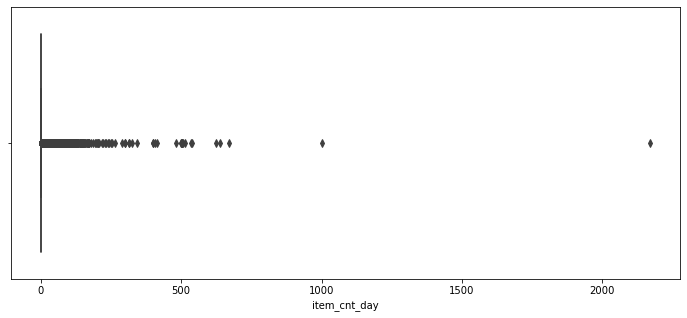

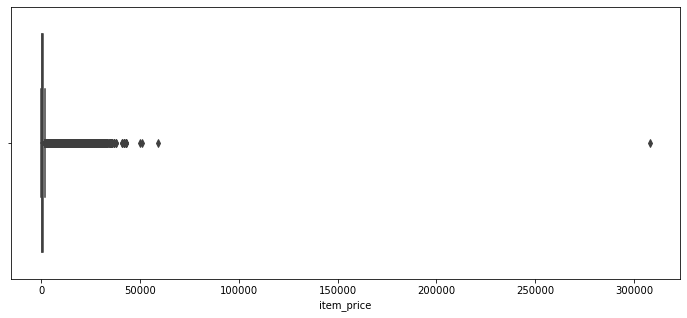

In [122]:
plt.figure(figsize=(12,5))
sns.boxplot(x='item_cnt_day', data=train_data)

plt.figure(figsize=(12,5))
sns.boxplot(x='item_price', data=train_data);

item_price와 item_cnt_day는 먼저 음수값을 가질 수 없으므로 제거해줍니다. 

In [123]:
train_data= train_data[(train_data['item_cnt_day'] > 0)] # 음의 값 제외 
train_data= train_data[(train_data['item_price'] > 0)] # 음의 값 제외 

np.min(train_data['item_cnt_day'])
np.min(train_data['item_price'])

0.07

In [125]:
print((train_data['item_price'].value_counts() < 500).sum())
print((train_data['item_price'].value_counts() < 50000).sum())

train_data = train_data[(train_data['item_cnt_day'] < 500)]
train_data = train_data[(train_data['item_price'] < 50000)]

19667
19964


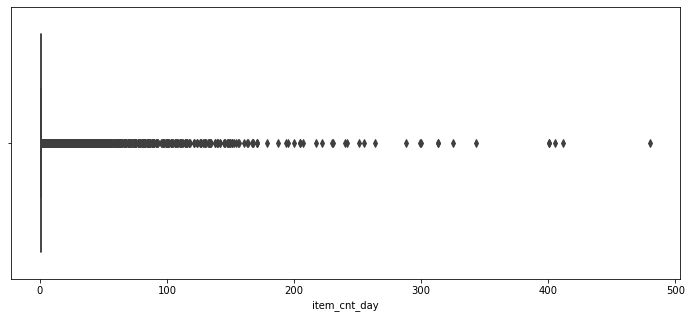

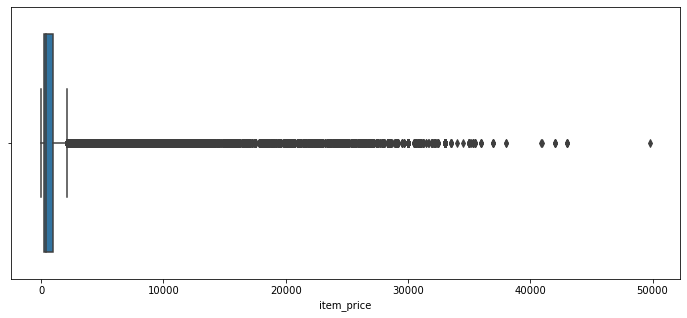

In [126]:
plt.figure(figsize=(12,5))
sns.boxplot(x='item_cnt_day', data=train_data)

plt.figure(figsize=(12,5))
sns.boxplot(x='item_price', data=train_data);

fundamental에서 배운 iqr로 하위 0.25~ 0.85에 해당하는 값을 제합니다. 

In [127]:
def outlier(df, col):
    q1 = df[col].quantile(0.25)
    q3 = df[col].quantile(0.85)
    iqr = q3 - q1

    return df[(df[col] < q1-1.5*iqr)|(df[col] < q3+1.5*iqr)]

train_data_ = outlier(train_data, 'item_price')
train_data_.head()

,item_id,item_category_id,item_kind_id,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
0,3045,19,5,0,42,1249.5,1.0,20,1,2013
1,965,37,7,0,18,299.0,1.0,9,1,2013
2,963,30,5,0,18,99.0,1.0,9,1,2013
3,963,30,5,0,18,99.0,1.0,9,1,2013
4,944,37,7,0,18,549.0,1.0,9,1,2013


이상치 제거해준 후에는 최대값, 최소값, 표준편차 등이 변했음을 알 수 있습니다. 

In [128]:
train_data.describe()

,item_id,item_category_id,item_kind_id,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
count,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06,2.928469e+06
mean,1.020027e+04,4.001637e+01,6.114687e+00,1.456971e+01,3.300300e+01,8.893252e+02,1.245032e+00,1.503268e+01,6.248401e+00,2.013777e+03
std,6.324393e+03,1.709801e+01,2.111875e+00,9.422937e+00,1.622541e+01,1.717571e+03,1.922269e+00,7.653076e+00,3.535923e+00,7.684591e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,7.000000e-02,1.000000e+00,0.000000e+00,1.000000e+00,2.013000e+03
25%,4.477000e+03,2.800000e+01,5.000000e+00,7.000000e+00,2.200000e+01,2.490000e+02,1.000000e+00,1.100000e+01,3.000000e+00,2.013000e+03
50%,9.355000e+03,4.000000e+01,6.000000e+00,1.400000e+01,3.100000e+01,3.990000e+02,1.000000e+00,1.100000e+01,6.000000e+00,2.014000e+03
75%,1.569100e+04,5.500000e+01,7.000000e+00,2.300000e+01,4.700000e+01,9.990000e+02,1.000000e+00,2.100000e+01,9.000000e+00,2.014000e+03
max,2.216900e+04,8.300000e+01,1.500000e+01,3.300000e+01,5.900000e+01,4.978200e+04,4.800000e+02,3.000000e+01,1.200000e+01,2.015000e+03


### 정규화(Normalization)
**수치형 변수**들에 대해 왜도(한 쪽에 치우쳐 랜덤하지 않는 분포)가 심한 데이터를 정규분포처럼 랜덤한 분포를 가지도록 log scale 해줍니다. <br> 
데이터가 한쪽에 쏠려 있는 정도를 왜도(skewness)라고 하고 데이터가 확 튀는, 특정 데이터만 높은 값을 가질때 첨도(kurtosis)라고 합니다. 이러한 데이터를 정규화해줘야합니다.

In [129]:
print(train_data_.columns)
print(len(train_data_.columns))

Index(['item_id', 'item_category_id', 'item_kind_id', 'date_block_num',
       'shop_id', 'item_price', 'item_cnt_day', 'location_id', 'month',
       'year'],
      dtype='object')
10


item_id는 제외하고 살펴볼거기 때문에, 총 8개를 살펴봅니다 

In [130]:
col_size = len(train_data_.columns)-1

for col in range(1, col_size): # [0]인 item_id는 제외합니다. 
    print('{}'.format(train_data_.columns[col]),
         '왜도: {:05.2f}'.format(train_data_[train_data_.columns[col]].skew()),
         '     ',
         '첨도: {:06.2f}'.format(train_data_[train_data_.columns[col]].kurt()))

item_category_id 왜도: 00.33       첨도: -00.50
item_kind_id 왜도: -0.01       첨도: 003.16
date_block_num 왜도: 00.22       첨도: -01.07
shop_id 왜도: -0.07       첨도: -01.02
item_price 왜도: 01.73       첨도: 002.43
item_cnt_day 왜도: 60.16       첨도: 8234.51
location_id 왜도: 00.37       첨도: -00.92
month 왜도: 00.10       첨도: -01.23


계산 결과, 왜도가 가장 심한 데이터는 item_cnt_day에 해당하고, 첨도가 가장 심한 데이터도 item_cnt_day에 해당합니다. 그리고 1~3 사이의 왜도, 첨도값도 큰편에 속하기 때문에 해당 데이터들은 정규화를 진행하도록 합니다. <br>
하지만 주의 사항은 item_cnt_day는 계약 건수를 의미하는 것으로 보이지만 음의 값이 정확히 어떤 의미인지 다른 컬럼을 통해 알기어려워 삭제해줍니다. 

<AxesSubplot:xlabel='item_kind_id', ylabel='Density'>

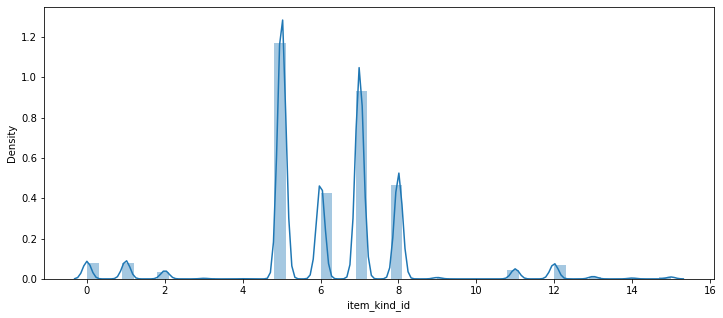

In [131]:
f, ax = plt.subplots(figsize = (12, 5))
sns.distplot(train_data_['item_kind_id'],hist=True)

<AxesSubplot:xlabel='item_cnt_day', ylabel='Density'>

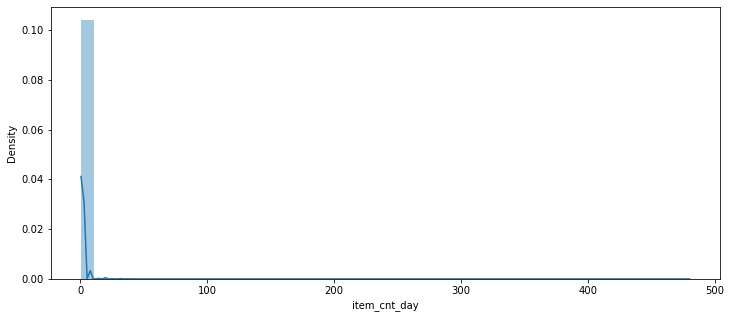

In [132]:
f, ax = plt.subplots(figsize = (12, 5))
sns.distplot(train_data_['item_cnt_day'],hist=True)

<AxesSubplot:xlabel='item_price', ylabel='Density'>

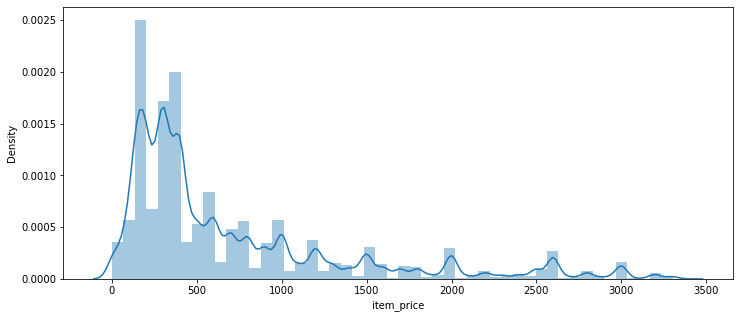

In [133]:
f, ax = plt.subplots(figsize = (12, 5))
sns.distplot(train_data_['item_price'],hist=True)

In [134]:
(train_data_['item_price'].value_counts() > 5000).sum()

57

In [135]:
train_data_.head() # train.csv dataframe 상위 5개 확인 

,item_id,item_category_id,item_kind_id,date_block_num,shop_id,item_price,item_cnt_day,location_id,month,year
0,3045,19,5,0,42,1249.5,1.0,20,1,2013
1,965,37,7,0,18,299.0,1.0,9,1,2013
2,963,30,5,0,18,99.0,1.0,9,1,2013
3,963,30,5,0,18,99.0,1.0,9,1,2013
4,944,37,7,0,18,549.0,1.0,9,1,2013


<AxesSubplot:ylabel='Density'>

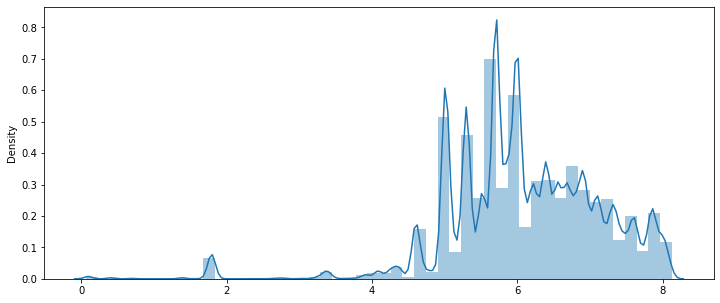

In [136]:
f, ax = plt.subplots(figsize = (12, 5))
sns.distplot(np.log1p(train_data_['item_price'].values),hist=True)

In [137]:
train_data_['item_price'] = np.log1p(train_data_['item_price'])

In [138]:
train_data = train_data_

# 메모리 버퍼 비우기 
del train_data_

---

## 데이터셋 분리 

In [139]:
random_state = 10

In [140]:
# random seed 
def set_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    
set_seeds(random_state)

In [141]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11098754 entries, 0 to 11098753
Data columns (total 8 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date_block_num    int8   
 1   shop_id           int8   
 2   item_id           int16  
 3   item_cnt_month    float16
 4   ID                float64
 5   location_id       int8   
 6   item_category_id  int16  
 7   item_kind_id      int16  
dtypes: float16(1), float64(1), int16(3), int8(3)
memory usage: 285.8 MB


date_block_num 13~32까지는 훈련 데이터, 33은 검증 데이터, 34는 테스트 데이터

In [142]:
matrix.to_pickle(join(data_path, 'data.pkl'))

# del train_data
gc.collect();

In [143]:
data = pd.read_pickle(join(data_path, 'data.pkl'))

In [144]:
print(data[data.date_block_num < 28].shape)
print(data[data.date_block_num >= 28].shape)

(9533332, 8)
(1565422, 8)


In [145]:
10218574/ 9533332

1.0718785415214744

In [146]:
X_train = data[data.date_block_num < 28].drop(['item_cnt_month'], axis=1) 
y_train = data[data.date_block_num < 28]['item_cnt_month']
X_valid = data[(data.date_block_num >= 28) & (data.date_block_num < 34)].drop(['item_cnt_month'], axis=1)
y_valid = data[(data.date_block_num >= 28) & (data.date_block_num < 34)]['item_cnt_month']

X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [147]:
del data
gc.collect()

22

---

## 모델 구현

### RandomSearch 수행 

!Error Report: GridSearch와 RandomSearch 커널 Dead 현상 

In [148]:
# def my_RandomSearch(model, X_train, y_train, param_random, verbose=2, n_jobs = 5):
#     # GridSearchCV 모델로 초기화
#     grid_model = RandomizedSearchCV(estimator = model, param_distributions=param_random, scoring='neg_mean_squared_error', \
#                               cv=5, verbose=verbose, n_jobs = n_jobs)

#     # 모델 fitting
#     grid_model.fit(X_train, y_train)

#     # 결과값 저장
#     params = grid_model.cv_results_['params']
#     score = grid_model.cv_results_['mean_test_score']

#     # 데이터 프레임 생성
#     results = pd.DataFrame(params)
#     results['score'] = score

#     # RMSLE 값 계산 후 정렬
#     results['RMSLE'] = np.sqrt(-1 * results['score'])
#     results = results.sort_values('RMSLE')
    
#     results['name'] = pd.Series([model.__class__.__name__])

#     return results

In [149]:
# # 탐색할 파라미터의 종류 (딕셔너리로 입력)
# param_random = {
#     'n_estimators': range(50, 80),
#     'max_depth': range(5, 10),
# }

In [150]:
# xgb_model = XGBRegressor(random_state=random_state)
# my_RandomSearch(xgb_model, X_train, y_train, param_random, verbose=2, n_jobs=5)

In [151]:
# lgb_model = lgb.LGBMRegressor(random_state=random_state)
# my_RandomSearch(lgb_model, X_train, y_train,  param_random, verbose=2, n_jobs=5)

---
### 하이퍼파라미터로 튜닝 - xgb
- Gradient Boosting보다 빠르다.
- 과적합 방지가 있다.
- CART ( Classification And Regression Trees ) 기반한 알고리즘
- 자체 교차검증 함수가 있다.

In [152]:
random_state = 35

In [153]:
best_xgb_model = XGBRegressor(max_depth=8, # 5 -10
                              learning_rate = 0.1, # 0.1 - 0.5  
                              colsample_bytree = 0.7,
                              subsample=0.8,
                              n_estimators=130, # 80 
                              random_state=random_state)

```
best_xgb_model.fit(X_train, 
                  y_train,
                  eval_metric = 'rmse',
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  verbose = True,
                  early_stopping_rounds = 6)
``` 
<br>
[23]	validation_0-rmse:1.13682	validation_1-rmse:0.99529<br>
[24]	validation_0-rmse:1.13423	validation_1-rmse:0.99308<br>
[25]	validation_0-rmse:1.13130	validation_1-rmse:0.98984<br>
[26]	validation_0-rmse:1.13031	validation_1-rmse:0.98887<br>
[27]	validation_0-rmse:1.12756	validation_1-rmse:0.98639<br>
[28]	validation_0-rmse:1.12703	validation_1-rmse:0.98613<br>
[29]	validation_0-rmse:1.12641	validation_1-rmse:0.98589

---
```
best_xgb_model = XGBRegressor(max_depth=8, # 5 -10
                              learning_rate = 0.1, # 0.1 - 0.5  
                              colsample_bytree = 0.7,
                              n_estimators=100, # 80 
                              random_state=random_state)
 ```                             
 <br>
[81]	validation_0-rmse:1.11884	validation_1-rmse:0.97864 <br>
[82]	validation_0-rmse:1.11862	validation_1-rmse:0.97852 <br>
[83]	validation_0-rmse:1.11831	validation_1-rmse:0.97854 <br>
[84]	validation_0-rmse:1.11819	validation_1-rmse:0.97859 <br>
[85]	validation_0-rmse:1.11816	validation_1-rmse:0.97861 <br>
[86]	validation_0-rmse:1.11786	validation_1-rmse:0.97867 <br>
[87]	validation_0-rmse:1.11757	validation_1-rmse:0.97884 <br>
[88]	validation_0-rmse:1.11742	validation_1-rmse:0.97855

---
```
XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.15, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=150, n_jobs=12, num_parallel_tree=1, random_state=10,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='approx', validate_parameters=1, verbosity=None)
```
[87]	validation_0-rmse:1.10845	validation_1-rmse:0.97654<br>
[88]	validation_0-rmse:1.10821	validation_1-rmse:0.97618<br>
[89]	validation_0-rmse:1.10810	validation_1-rmse:0.97624<br>
[90]	validation_0-rmse:1.10796	validation_1-rmse:0.97631<br>
[91]	validation_0-rmse:1.10792	validation_1-rmse:0.97622<br>
[92]	validation_0-rmse:1.10779	validation_1-rmse:0.97630<br>
[93]	validation_0-rmse:1.10765	validation_1-rmse:0.97628<br>


!Error Report: base score error <br>
iteration이 끝까지 돌지 못하고 30정도에서 멈춤현상이 있었습니다. scikit-learn 패키지 버전 문제이므로 버전을 업그레이드 해줬습니다. 

In [154]:
# !pip install --upgrade scikit-learn #base score error 해결 

In [155]:
best_xgb_model.fit(X_train, 
                  y_train,
                  eval_metric = 'rmse',
                  eval_set = [(X_train, y_train), (X_valid, y_valid)],
                  verbose = True,
                  early_stopping_rounds = 6)

[0]	validation_0-rmse:1.24800	validation_1-rmse:1.09918
[1]	validation_0-rmse:1.23568	validation_1-rmse:1.08615
[2]	validation_0-rmse:1.22573	validation_1-rmse:1.07540
[3]	validation_0-rmse:1.21752	validation_1-rmse:1.06756
[4]	validation_0-rmse:1.21488	validation_1-rmse:1.06254
[5]	validation_0-rmse:1.20911	validation_1-rmse:1.05698
[6]	validation_0-rmse:1.20614	validation_1-rmse:1.05349
[7]	validation_0-rmse:1.20035	validation_1-rmse:1.04904
[8]	validation_0-rmse:1.19790	validation_1-rmse:1.04648
[9]	validation_0-rmse:1.19286	validation_1-rmse:1.04183
[10]	validation_0-rmse:1.19004	validation_1-rmse:1.03950
[11]	validation_0-rmse:1.18679	validation_1-rmse:1.03683
[12]	validation_0-rmse:1.18505	validation_1-rmse:1.03520
[13]	validation_0-rmse:1.18122	validation_1-rmse:1.03162
[14]	validation_0-rmse:1.17595	validation_1-rmse:1.02698
[15]	validation_0-rmse:1.17318	validation_1-rmse:1.02535
[16]	validation_0-rmse:1.16977	validation_1-rmse:1.02197
[17]	validation_0-rmse:1.16660	validation

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.1, max_delta_step=0, max_depth=8,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=130, n_jobs=12, num_parallel_tree=1, random_state=35,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='approx', validate_parameters=1, verbosity=None)

### Predict & expm1

In [156]:
best_xgb_prediction = best_xgb_model.predict(X_valid)
best_xgb_prediction = np.expm1(best_xgb_prediction)
best_xgb_prediction

array([0.1287745 , 0.1001526 , 0.1287745 , ..., 0.14130788, 0.02929185,
       0.05186033], dtype=float32)

In [157]:
y_test = best_xgb_model.predict(X_test)

In [158]:
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": y_test
})

submission_csv_path = '{}/submission_{}_RMSE.csv'.format(data_path, 'xgb3')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))  

/home/aiffel-dj19/aiffel/kaggle_predict_sales/data/submission_xgb3_RMSE.csv saved!


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

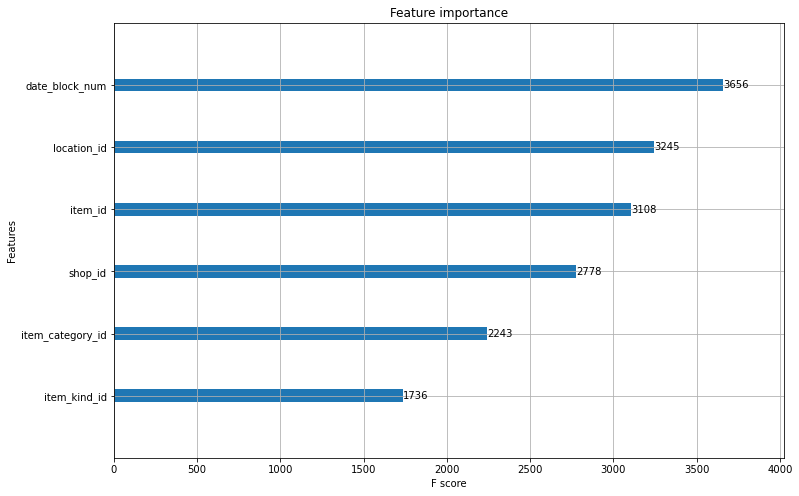

In [159]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
xgb.plot_importance(best_xgb_model, ax = ax)

### 하이퍼파라미터로 튜닝 - lgb

```
best_lgbm_model = lgb.LGBMRegressor(max_depth=10,
                                    learning_rate = 0.1, 
                                    colsample_bytree = 0.7,
                                    n_estimators=30, 
                                    random_state=random_state)
```
<br>
[27]	training's rmse: 1.16571	training's l2: 1.35887	valid_1's rmse: 1.02124	valid_1's l2: 1.04292<br>
[28]	training's rmse: 1.16318	training's l2: 1.35299	valid_1's rmse: 1.01843	valid_1's l2: 1.03721<br>
[29]	training's rmse: 1.16107	training's l2: 1.34807	valid_1's rmse: 1.01566	valid_1's l2: 1.03156<br>
[30]	training's rmse: 1.16066	training's l2: 1.34712	valid_1's rmse: 1.01538	valid_1's l2: 1.031<br>
Did not meet early stopping. Best iteration is:<br>
[30]	training's rmse: 1.16066	training's l2: 1.34712	valid_1's rmse: 1.01538	valid_1's l2: 1.031

In [160]:
best_lgbm_model = lgb.LGBMRegressor(max_depth=60,
                                    learning_rate = 0.09, 
                                    colsample_bytree = 0.7,
                                    n_estimators=100, 
                                    random_state=random_state,
                                   num_leaves = 30)

In [161]:
best_lgbm_model.fit(X_train, 
          y_train,
          eval_metric = 'rmse',
          eval_set = [(X_train, y_train), (X_valid, y_valid)],
          verbose = True,
          early_stopping_rounds = 6)

[1]	training's rmse: 1.23593	training's l2: 1.52753	valid_1's rmse: 1.07967	valid_1's l2: 1.16569
Training until validation scores don't improve for 6 rounds
[2]	training's rmse: 1.23114	training's l2: 1.5157	valid_1's rmse: 1.07522	valid_1's l2: 1.15609
[3]	training's rmse: 1.22705	training's l2: 1.50565	valid_1's rmse: 1.07114	valid_1's l2: 1.14734
[4]	training's rmse: 1.22055	training's l2: 1.48973	valid_1's rmse: 1.06455	valid_1's l2: 1.13326
[5]	training's rmse: 1.21847	training's l2: 1.48468	valid_1's rmse: 1.06276	valid_1's l2: 1.12946
[6]	training's rmse: 1.21566	training's l2: 1.47783	valid_1's rmse: 1.06035	valid_1's l2: 1.12435
[7]	training's rmse: 1.20869	training's l2: 1.46092	valid_1's rmse: 1.0523	valid_1's l2: 1.10733
[8]	training's rmse: 1.20453	training's l2: 1.45089	valid_1's rmse: 1.04871	valid_1's l2: 1.09978
[9]	training's rmse: 1.20257	training's l2: 1.44619	valid_1's rmse: 1.0471	valid_1's l2: 1.09641
[10]	training's rmse: 1.20048	training's l2: 1.44116	valid_1'

LGBMRegressor(colsample_bytree=0.7, learning_rate=0.09, max_depth=60,
              num_leaves=30, random_state=35)

### Predict & expm1

In [162]:
best_lgbm_prediction = best_lgbm_model.predict(X_test)
best_lgbm_prediction = np.expm1(best_lgbm_prediction)
y_test = best_lgbm_model.predict(X_test)

In [163]:
submission = pd.DataFrame({
    "ID": test.index,
    "item_cnt_month": y_test
})

submission_csv_path = '{}/submission_{}_RMSE.csv'.format(data_path, 'lgb2')
submission.to_csv(submission_csv_path, index=False)
print('{} saved!'.format(submission_csv_path))  

/home/aiffel-dj19/aiffel/kaggle_predict_sales/data/submission_lgb2_RMSE.csv saved!


<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

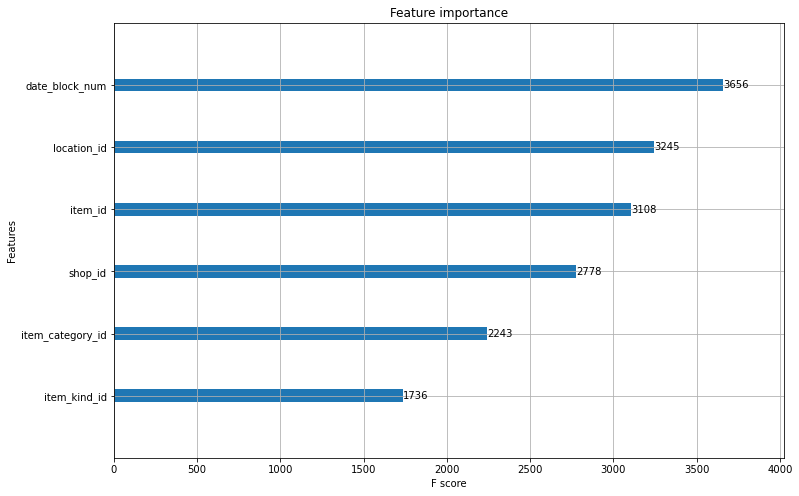

In [164]:
fig, ax = plt.subplots(1, 1, figsize=(12,8))
xgb.plot_importance(best_xgb_model, ax = ax)

# 대표 후기 

인표님: 'Hello world!'를 출력해본지 한 달 정도 지난 시점에 생애 첫 해커톤을 진행했습니다. 이제 겨우 걸음마 시작했는데 갑자기 100m 달려보라고 한 느낌이었지만 다행히 Aiffel에서 유능한 분들과 팀을 구성해주셨습니다. 잘 못한다고 모진 구박을 받을까봐 걱정 했지만 다행히 착하신 성은님과 석현님을 만나 정말 많이 배울수 있었던 좋은 기회였습니다. 저에게는 배울 수 있는 좋은 기회였지만 성은님과 석현님에게 부담이 가중되어 많이 힘드셨을텐데 그 부분에 있어서는 많은 죄송함을 느낍니다. 돈 열심히 벌어서 오프라인이 되면 꼭 밥 한끼를 사드리도록 하겠습니다.

# 회고 
하이퍼 파라미터의 그리드서치와 랜덤서치를 시도하였으나 시간과 예산이 부족하여 제대로 진행하지 못했다. 이전 경험(E09)를 살려 각각의 수치를 대강 넣어주면서 RMSE를 평가하였다. 

max_depth는 과적합 방지를 위해 사용하는 것으로 일단 10을 주었다.
learning_rate는 학습율로 0.1 이 대체로 가장 좋아서 채택하였다.
subsample,colsample_bytree는 의사결정나무 모형에서 사용되는 변수로 두 조모수 설정이 상호작용 하므로 적당한 값을 주었다
min_child_weight 또한 max_depth와 같이 과적합 방지 조모수이다.
n_estimators는 epoch로 너무 높지 않고 적지않게 설정해주었다.

모델 설계 후 예측 결과에 영향을 미친 값들을 확인해보았더니 가장 영향을 많이 준 것은 물품 그 자체와 가게 그 자체였다.
즉 해당 항목의 인기에 따라 판매량이 좌우되는 것이다.

반대로 영향을 가장 적게 미친것은 상점이 위치한 도시로 어느 도시에 있든 팔릴 물건은 팔리고 안팔리는건 안팔린다는 것이다.